### Imports

In [196]:
import datetime as dt
import numpy as np # type: ignore
import pandas as pd # type: ignore
import yfinance as yf # type: ignore
import matplotlib.pyplot as plt
from math import log, sqrt
import cvxopt as opt
from cvxopt import blas, solvers

### Selected Stocks

In [197]:
companies = ["AAPL", "CAT", "CVX", "JPM", "KO", "MCD", "MSFT", "NKE"]

In [198]:
start_date = dt.datetime(2000, 1, 1)
end_date = dt.datetime(2024, 5, 1)

df_companies = yf.download(companies, start_date, end_date)
companies_adj_close = df_companies['Adj Close']
quarterly_stock_data = companies_adj_close.resample('QE').last()
selected = list(quarterly_stock_data.columns[0:])

# Creating a CSV
#csv_file_path = (r"C:\Users\joelk\Documents\CODING\CODECADEMY COURSES\Analysing Financial Data with Python\Capstone Project\quarterly_stock_data.csv")
#quarterly_stock_data.to_csv(csv_file_path)

#print(quarterly_stock_data)
#print(selected)

#quarterly_stock_data.plot()
#plt.xlabel('Quarter')
#plt.ylabel('Value ($)')
#plt.show()

[*********************100%%**********************]  8 of 8 completed


### Quarterly Returns

In [199]:
returns_quarterly = quarterly_stock_data[selected].pct_change()
print(returns_quarterly)    

Ticker          AAPL       CAT       CVX       JPM        KO       MCD  \
Date                                                                     
2000-03-31       NaN       NaN       NaN       NaN       NaN       NaN   
2000-06-30 -0.228716 -0.134054 -0.076026 -0.203393  0.227668 -0.118729   
2000-09-30 -0.508354 -0.076076  0.013044  0.009728 -0.037202 -0.083492   
2000-12-31 -0.422330  0.543415 -0.001830 -0.009458  0.108560  0.133666   
2001-03-31  0.483698 -0.054840  0.047741 -0.004590 -0.256241 -0.219118   
...              ...       ...       ...       ...       ...       ...   
2023-06-30  0.177916  0.081042 -0.026165  0.124867 -0.021786  0.072902   
2023-09-30 -0.116146  0.115025  0.081922  0.003960 -0.063033 -0.112441   
2023-12-31  0.126007  0.088637 -0.106135  0.181597  0.061080  0.132275   
2024-03-31 -0.108197  0.245063  0.069062  0.184804  0.046485 -0.043694   
2024-06-30 -0.006706 -0.083619  0.022379 -0.037152  0.009644 -0.031601   

Ticker          MSFT       NKE  
Date

In [200]:
mean_returns = returns_quarterly.mean()
cov_matrix = returns_quarterly.cov()
var_quarterly = returns_quarterly.var()
std_quarterly = returns_quarterly.std()
corr_coefficient = returns_quarterly.corr()

#csv_file_path1 = (r"C:\Users\joelk\Documents\CODING\CODECADEMY COURSES\Analysing Financial Data with Python\Capstone Project\returns_quarterly.csv")
#returns_quarterly.to_csv(csv_file_path1)

print((mean_returns * 100).round(2))
print(cov_matrix)
#print(var_quarterly)
#print((std_quarterly * 100).round(2))
#print(corr_coefficient)

Ticker
AAPL    7.62
CAT     4.96
CVX     2.91
JPM     3.16
KO      2.05
MCD     3.26
MSFT    3.53
NKE     4.16
dtype: float64
Ticker      AAPL       CAT       CVX       JPM        KO       MCD      MSFT  \
Ticker                                                                         
AAPL    0.044577  0.007379  0.006207  0.008535  0.000923  0.006216  0.017299   
CAT     0.007379  0.028034  0.009568  0.014205  0.004900  0.005610  0.006662   
CVX     0.006207  0.009568  0.013796  0.005721  0.003119  0.003755  0.003629   
JPM     0.008535  0.014205  0.005721  0.023486  0.003678  0.006843  0.010192   
KO      0.000923  0.004900  0.003119  0.003678  0.006831  0.004409  0.001279   
MCD     0.006216  0.005610  0.003755  0.006843  0.004409  0.011561  0.003603   
MSFT    0.017299  0.006662  0.003629  0.010192  0.001279  0.003603  0.019030   
NKE     0.005064  0.010263  0.001643  0.008716  0.005098  0.006275  0.004361   

Ticker       NKE  
Ticker            
AAPL    0.005064  
CAT     0.010263

### Returns Portfolios Function

In [201]:
def return_portfolios(mean_returns, cov_matrix, num_portfolios=10000):
    np.random.seed(1)
    portfolio_returns = []
    portfolio_volatility = []
    stock_weights = []
    
    selected = (mean_returns.axes)[0]
    num_assets = len(selected)
    
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        returns = np.dot(weights, mean_returns)
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        portfolio_returns.append(returns)
        portfolio_volatility.append(volatility)
        stock_weights.append(weights)
        
    portfolio = {'Returns': portfolio_returns, 'Volatility': portfolio_volatility}
    
    for counter, symbol in enumerate(selected):
        portfolio[symbol + 'Weight'] = [Weight[counter] for Weight in stock_weights]
        
    df = pd.DataFrame(portfolio)
    
    column_order = ['Returns', 'Volatility'] + [stock+'Weight' for stock in selected]
    
    df = df[column_order]
    
    return df

### A set of Random Portfolios

       Returns  Volatility  AAPLWeight  CATWeight  CVXWeight  JPMWeight  \
0     0.047056    0.109898    0.188637   0.325834   0.000052   0.136758   
1     0.039912    0.093496    0.103854   0.141036   0.109725   0.179357   
2     0.038564    0.085647    0.102050   0.136625   0.034331   0.048445   
3     0.048509    0.104072    0.253107   0.258368   0.024561   0.011279   
4     0.042332    0.090255    0.200060   0.111354   0.144502   0.065897   
...        ...         ...         ...        ...        ...        ...   
9995  0.034735    0.096569    0.046219   0.091036   0.265858   0.320989   
9996  0.043328    0.094479    0.156243   0.187706   0.052913   0.025346   
9997  0.041882    0.090308    0.174881   0.127515   0.017767   0.038046   
9998  0.040083    0.090212    0.144791   0.193054   0.085204   0.076360   
9999  0.033332    0.079978    0.013685   0.010183   0.051753   0.000353   

      KOWeight  MCDWeight  MSFTWeight  NKEWeight  
0     0.066384   0.041769    0.084254   0.156312

<Axes: xlabel='Volatility', ylabel='Returns'>

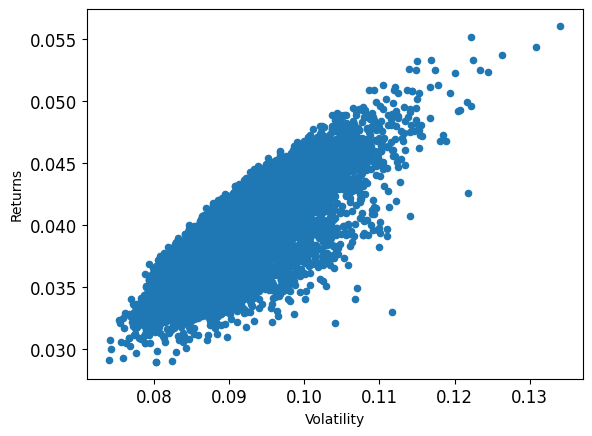

In [202]:
random_portfolios = return_portfolios(mean_returns, cov_matrix)
print(random_portfolios)

#csv_file_path1 = (r"C:\Users\joelk\Documents\CODING\CODECADEMY COURSES\Analysing Financial Data with Python\Capstone Project\random_portfolios.csv")
#random_portfolios.to_csv(csv_file_path1)

random_portfolios.plot.scatter(x = 'Volatility', y = 'Returns', fontsize=12)

### Optimal Portfolio Function

In [203]:
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.values)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    G = -opt.matrix(np.eye(n)) 
    h = opt.matrix(0.0, (n,1))
    A = opt.matrix(1.0, (1,n))
    b = opt.matrix(1.0)
    
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] for mu in mus]

    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]

    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])

    weights = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(weights), returns, risks

### Risk Tolerance Function

### Efficient Frontier Calculations

In [204]:
weights, returns, risks = optimal_portfolio(returns_quarterly[1:])
print(weights)

print(risks)

     pcost       dcost       gap    pres   dres
 0: -4.1151e-02 -1.0753e+00  1e+00  3e-16  3e+00
 1: -4.1692e-02 -8.5299e-02  4e-02  9e-17  1e-01
 2: -7.2850e-02 -8.8464e-02  2e-02  2e-16  7e-03
 3: -7.3864e-02 -7.4161e-02  3e-04  2e-16  1e-04
 4: -7.4015e-02 -7.4018e-02  3e-06  2e-16  1e-06
 5: -7.4016e-02 -7.4017e-02  3e-08  2e-16  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.1095e-02 -1.0752e+00  1e+00  0e+00  3e+00
 1: -4.1633e-02 -8.5184e-02  4e-02  5e-17  1e-01
 2: -7.2542e-02 -8.8145e-02  2e-02  2e-16  6e-03
 3: -7.3584e-02 -7.3889e-02  3e-04  2e-16  1e-04
 4: -7.3743e-02 -7.3746e-02  3e-06  1e-16  1e-06
 5: -7.3745e-02 -7.3745e-02  3e-08  2e-16  1e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.1031e-02 -1.0751e+00  1e+00  0e+00  3e+00
 1: -4.1567e-02 -8.5055e-02  4e-02  2e-16  1e-01
 2: -7.2197e-02 -8.7786e-02  2e-02  8e-16  5e-03
 3: -7.3270e-02 -7.3583e-02  3e-04  1e-16  1e-04
 4: -7.3438e-02 -7.3441e

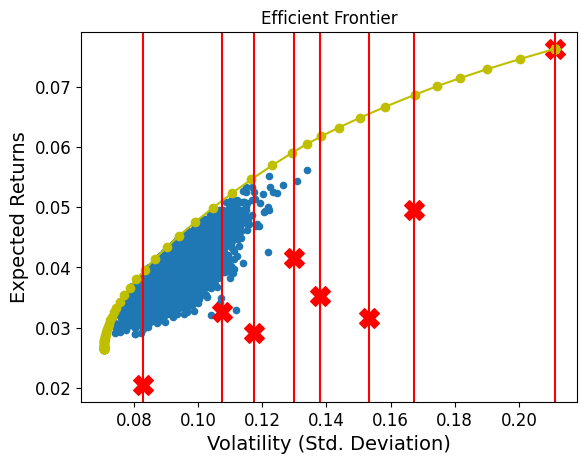

In [205]:
random_portfolios.plot.scatter(x = 'Volatility', y = 'Returns', fontsize=12)

plt.plot(risks, returns, 'y-o')
plt.ylabel('Expected Returns', fontsize=14)
plt.xlabel('Volatility (Std. Deviation)', fontsize=14)
plt.title('Efficient Frontier')

single_asset_std=np.sqrt(np.diagonal(cov_matrix))
plt.scatter(single_asset_std,mean_returns,marker='X',color='red',s=200)
for xc in single_asset_std:
    plt.axvline(x=xc, color='red')

#plt.savefig(r"C:\Users\joelk\Documents\CODING\CODECADEMY COURSES\Analysing Financial Data with Python\Capstone Project\Efficient Frontier.jpg")
#plt.show()

## Financial Statistics Functions

In [206]:
# Calculate Simple Return
def calculate_simple_return(start_price, end_price, dividend=0):
    simple_return = (end_price - start_price + dividend) / start_price
    return simple_return

# Calculate Log Return
def calculate_log_return(start_price, end_price):
    return log(end_price / start_price)

def get_log_returns(prices):
    returns = []
    for i in range(len(prices) - 1):
        returns.append(calculate_log_return(prices.iloc[i], prices.iloc[i+1]))
    return returns

## Required Price Data

In [207]:
# Extracting Start and End Prices
AAPL_prices = quarterly_stock_data["AAPL"]
AAPL_start_price = quarterly_stock_data["AAPL"].iloc[0]
AAPL_end_price = quarterly_stock_data["AAPL"].iloc[-1]

CAT_prices = quarterly_stock_data["CAT"]
CAT_start_price = quarterly_stock_data["CAT"].iloc[0]
CAT_end_price = quarterly_stock_data["CAT"].iloc[-1]

CVX_prices = quarterly_stock_data["CVX"]
CVX_start_price = quarterly_stock_data["CVX"].iloc[0]
CVX_end_price = quarterly_stock_data["CVX"].iloc[-1]

JPM_prices = quarterly_stock_data["JPM"]
JPM_start_price = quarterly_stock_data["JPM"].iloc[0]
JPM_end_price = quarterly_stock_data["JPM"].iloc[-1]

KO_prices = quarterly_stock_data["KO"]
KO_start_price = quarterly_stock_data["KO"].iloc[0]
KO_end_price = quarterly_stock_data["KO"].iloc[-1]

MCD_prices = quarterly_stock_data["MCD"]
MCD_start_price = quarterly_stock_data["MCD"].iloc[0]
MCD_end_price = quarterly_stock_data["MCD"].iloc[-1]

MSFT_prices = quarterly_stock_data["MSFT"]
MSFT_start_price = quarterly_stock_data["MSFT"].iloc[0]
MSFT_end_price = quarterly_stock_data["MSFT"].iloc[-1]

NKE_prices = quarterly_stock_data["NKE"]
NKE_start_price = quarterly_stock_data["NKE"].iloc[0]
NKE_end_price = quarterly_stock_data["NKE"].iloc[-1]

## Simple Rate of Return

In [208]:
# Calculating Simple Return
AAPL_simple_return = calculate_simple_return(AAPL_start_price, AAPL_end_price)
print(f"{AAPL_simple_return: .2%}")

CAT_simple_return = calculate_simple_return(CAT_start_price, CAT_end_price)
print(f"{CAT_simple_return: .2%}")

CVX_simple_return = calculate_simple_return(CVX_start_price, CVX_end_price)
print(f"{CVX_simple_return: .2%}")

JPM_simple_return = calculate_simple_return(JPM_start_price, JPM_end_price)
print(f"{JPM_simple_return: .2%}")

KO_simple_return = calculate_simple_return(KO_start_price, KO_end_price)
print(f"{KO_simple_return: .2%}")

MCD_simple_return = calculate_simple_return(MCD_start_price, MCD_end_price)
print(f"{MCD_simple_return: .2%}")

MSFT_simple_return = calculate_simple_return(MSFT_start_price, MSFT_end_price)
print(f"{MSFT_simple_return: .2%}")

NKE_simple_return = calculate_simple_return(NKE_start_price, NKE_end_price)
print(f"{NKE_simple_return: .2%}")

 16491.71%
 3087.16%
 744.07%
 570.27%
 415.79%
 1220.05%
 1084.28%
 2311.36%


## Logarithmic Rate of Return

In [209]:
AAPL_log_return = get_log_returns(AAPL_prices)
#print(AAPL_log_return)

CAT_log_return = get_log_returns(CAT_prices)
#print(CAT_log_return)

CVX_log_return = get_log_returns(CVX_prices)
#print(CVX_log_return)

JPM_log_return = get_log_returns(JPM_prices)
#print(JPM_log_return)

KO_log_return = get_log_returns(KO_prices)
#print(KO_log_return)

MCD_log_return = get_log_returns(MCD_prices)
#print(MCD_log_return)

MSFT_log_return = get_log_returns(MSFT_prices)
#print(MSFT_log_return)

NKE_log_return = get_log_returns(NKE_prices)
#print(NKE_log_return)

In [210]:
AAPL_total_log_return = sum(AAPL_log_return)
print(f"{AAPL_total_log_return: .2%}")

CAT_total_log_return = sum(CAT_log_return)
print(f"{CAT_total_log_return: .2%}")

CVX_total_log_return = sum(CVX_log_return)
print(f"{CVX_total_log_return: .2%}")

JPM_total_log_return = sum(JPM_log_return)
print(f"{JPM_total_log_return: .2%}")

KO_total_log_return = sum(KO_log_return)
print(f"{KO_total_log_return: .2%}")

MCD_total_log_return = sum(MCD_log_return)
print(f"{MCD_total_log_return: .2%}")

MSFT_total_log_return = sum(MSFT_log_return)
print(f"{MSFT_total_log_return: .2%}")

NKE_total_log_return = sum(NKE_log_return)
print(f"{NKE_total_log_return: .2%}")

 511.15%
 346.17%
 213.31%
 190.25%
 164.05%
 258.03%
 247.17%
 318.28%
